In [1]:
from attention_recreation.model import EncoderDecoder, make_encoder, make_input_id_encoder, make_decoder
from datasets import load_dataset
from tokenizers import Tokenizer, decoders
import torch
import os
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
BATCH_SIZE = 32

In [3]:
# load data
ds = load_dataset("Helsinki-NLP/opus-100", "de-en", streaming=False)
en_generator = (x["translation"]["en"] for x in ds["train"])
de_generator = (x["translation"]["de"] for x in ds["train"])

# get tokenizers
en_tokenizer: Tokenizer = Tokenizer.from_file("../tokenizers/basic_en_tokenizer.json")
de_tokenizer: Tokenizer = Tokenizer.from_file("../tokenizers/basic_de_tokenizer.json")


# en_tokenizer.enable_padding(pad_id=en_tokenizer.token_to_id("[PAD]"), pad_token="[PAD]")


# process dataset outside of gpu
def process_ds(batch):
    en_tokenized = en_tokenizer.encode_batch([x["en"] for x in batch["translation"]])
    batch["en_tokenized"] = [x.tokens for x in en_tokenized]
    batch["en_length"] = [len(x.tokens) for x in en_tokenized]
    return batch


In [ ]:
# Preprocess and tokenize
def tokenize(example):
    en_encoded = en_tokenizer.encode(example["translation"]["en"])
    de_encoded = de_tokenizer.encode(example["translation"]["de"])
    return {"en_input_ids": en_encoded.ids, "de_input_ids": de_encoded.ids, "en_length": len(en_encoded.ids)}


tokenized_ds = ds.map(tokenize, remove_columns="translation", num_proc=16)

Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/1000000 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [14]:
tokenized_ds["train"][0]

{'en_input_ids': [2325,
  10,
  86,
  3917,
  2177,
  2227,
  2180,
  10,
  86,
  3011,
  2197,
  2167,
  4193,
  2176,
  2195,
  15,
  10,
  2646,
  2195,
  2320],
 'de_input_ids': [6615, 4726, 14508, 1495, 1597, 3029, 4340, 1596, 17],
 'en_length': 20}

In [ ]:
processed_ds = ds.map(process_ds, batched=True, batch_size=BATCH_SIZE, num_proc=os.cpu_count(), remove_columns="translation")

In [6]:
data = processed_ds["train"]["en_length"]

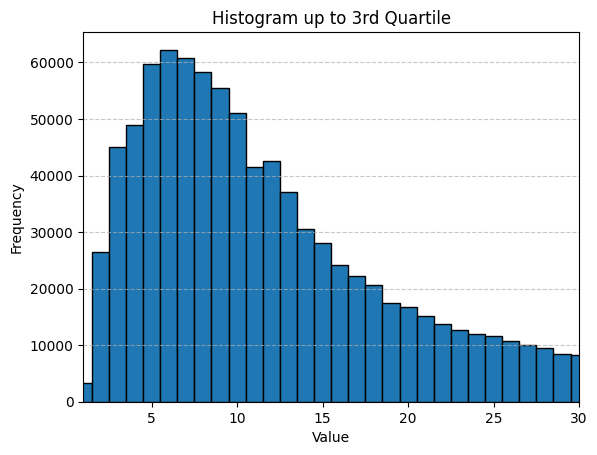

In [9]:
# Calculate 75th percentile
q3 = np.percentile(data, 75)

# Create histogram
plt.hist(data, bins=range(min(data), max(data) + 2), edgecolor='black', align='left')
plt.title("Histogram up to 3rd Quartile")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set x-axis max to Q3 + 10
plt.xlim(left=min(data), right=q3+10)
plt.show()


In [8]:
for token_list, length in zip(processed_ds["train"][:BATCH_SIZE]["en_tokenized"], processed_ds["train"][:BATCH_SIZE]["en_length"]):
    print(token_list, length)

['It', "'", 's', 'gre', 'ed', 'that', 'it', "'", 's', 'gonna', 'be', 'the', 'death', 'of', 'you', ',', "'", 'cause', 'you', '...'] 20
['Ve', 'ga', '.'] 3
['Just', 'say', 'when', '.'] 4
['-', 'Wait', '.'] 3
['I', 'don', "'", 't', 'wanna', 'be', 'here', '.'] 8
['Okay', ',', 'so', '90', 'percent', 'of', 'my', 'photographic', 'process', 'is', ',', 'in', 'fact', ',', 'not', 'photographic', '.'] 17
['So', 'lovely', '.'] 3
['Thank', 'you', ',', 'colonel', '.'] 5
['Martin', '!'] 2
['Do', 'I', 'have', 'to', '?'] 5
['Please', 'sit', '.'] 3
['Leo', '!'] 2
['No', ',', 'honestly', ',', 'I', 'think', 'that', 'you', 'should', 'find', 'out', 'What', "'", 's', 'going', 'on', 'with', 'your', 'dad', '.'] 20
['How', 'you', 'holding', 'up', '?'] 5
['-', 'Let', "'", 's', 'go', '.'] 6
['I', 'am', 'really', 'allowed', 'to', 'get', 'up', ',', 'Doctor', '?'] 10
['-', 'What', 'will', 'you', 'do', 'with', 'it', '?'] 8
['-', 'Can', 'we', 'talk', '?'] 5
['Get', 'down', '!'] 3
['And', 'if', 'the', 'dis', 'ruption', 

model stuff

In [3]:
d_model=512
d_inner_layer=2048
n_heads=8
n_encoder_stacks=7
n_decoder_stacks=7
source_vocab_size=en_tokenizer.get_vocab_size()
target_vocab_size = de_tokenizer.get_vocab_size()

In [4]:
encoder_decoder_model = EncoderDecoder(
    d_model=d_model,
    d_inner_layer=d_inner_layer,
    n_heads=n_heads,
    n_encoder_stacks=n_encoder_stacks,
    n_decoder_stacks=n_decoder_stacks,
    source_vocab_size=source_vocab_size,
    target_vocab_size=target_vocab_size,
    input_id_encoder_factory=make_input_id_encoder,
    encoder_factory=make_encoder,
    decoder_factory=make_decoder,
)

In [5]:

encoder_decoder_model

EncoderDecoder(
  (source_id_encoder): InputIdEncoder(
    (token_encoder): Embedding(30000, 512)
    (positional_encoder): SinePositionEncoder(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (target_id_encoder): InputIdEncoder(
    (token_encoder): Embedding(30000, 512)
    (positional_encoder): SinePositionEncoder(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-6): 7 x EncoderLayer(
        (mha_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mha_sublayer): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (mha_dropout): Dropout(p=0.1, inplace=False)
        (mlp_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp_sublayer): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): Linear(in_features=2048, out_features=512, bia